In [1]:
# plot and predict the slices 

import tensorflow as tf
# set TF to 1.x
tf.compat.v1.disable_v2_behavior()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import os

from utils.normalize_data import normalizeStandard, reTransformStandard, reTransformTarget

from typing import List

from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

%matplotlib inline

font = {'size'   : 16}

plt.rc('font', **font)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
print(tf.__version__)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# LIMIT GPU MEMORY USAGE
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#   except RuntimeError as e:
#     print(e)

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1028)])
    except RuntimeError as e:
        print(e)

        
        
plt.rcParams.update({'font.size': 16})

2.3.1


In [3]:
# Specify the case you want to predict
CASE = 'UPRIME5'

# Specify the trained model you want to use
MODEL_CASE='UPRIME5'

# Specifiy the filter width to predict (as str 16 or 20 so far)
FILTER_WIDTH=str(20)

path_to_slices = '/media/max/HDD3/DNS_Data/Planar/NX512/'+CASE+'/postProcess_DNN'
path_to_models = '/home/max/Python/Data_driven_models/TF2/trained_models/'

In [4]:
# load a slice file
mySlice_df = pd.read_parquet(join(path_to_slices,'slice_plane_x_'+FILTER_WIDTH+'_DNN_'+CASE+'.parquet'))

columns = list(mySlice_df.columns)
print(columns)

mySlice_index = mySlice_df.index

# TODO: update FEATURES

# Features and Target
FEATURES: List[str] = [#'c_bar',
                       'c_tilde',
                       'omega_model_planar',
                       'UP_delta',
                       'SGS_flux',
                       'Delta_LES',
                       'mag_grad_c_tilde',
                       'mag_grad_U',
                       'c_prime']
    
TARGET: List[str] = ['omega_DNS_filtered']


['c_bar', 'c_tilde', 'omega_DNS_filtered', 'omega_model_planar', 'mag_grad_U', 'mag_grad_c', 'mag_grad_c_tilde', 'grad_c_tilde_x', 'grad_c_tilde_y', 'grad_c_tilde_z', 'lambda_1', 'lambda_3', 'UP_delta', 'SGS_flux', 'c_prime', 'Delta_LES', 'filter_width', 'omega_DNS']


In [5]:
# reshape vectors to 2D array

mySlice_2D_array = np.zeros((512,512,len(columns)))

# fill array
for idx, c in enumerate(columns):
    mySlice_2D_array[:,:,idx] = mySlice_df[c].values.reshape(512,512)
    
    

## Plot the slices 

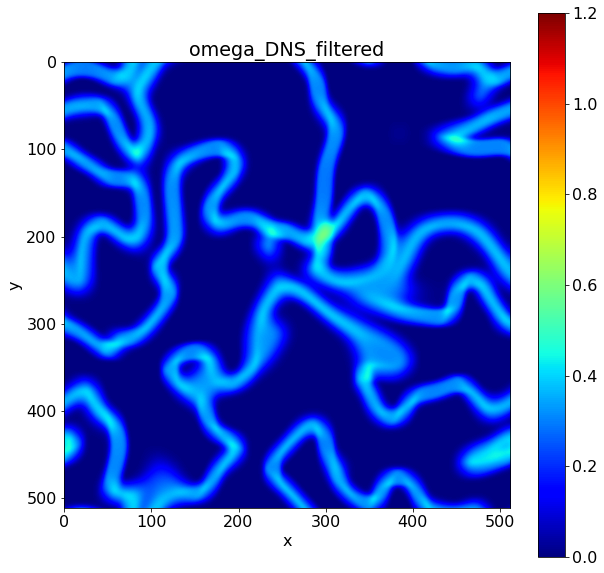

In [6]:
field = 'omega_DNS_filtered'

array_index = columns.index(field)

plt.figure(figsize=(10,10))
plt.imshow(mySlice_2D_array[:,:,array_index],cmap='jet',vmax=1.2)
plt.title(field)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

## Plot relative error in omega

In [7]:

mySlice_df['rel_error_omega'] = abs(mySlice_df['omega_DNS_filtered']-mySlice_df['omega_model_planar'])/mySlice_df['omega_DNS_filtered']


fig = px.scatter_3d(mySlice_df[mySlice_df['omega_DNS_filtered']>0.4], 
                    x='SGS_flux', 
                    y='mag_grad_c_tilde', 
                    z='c_prime',
                    color='rel_error_omega',
                    size='rel_error_omega',
                    width=800, height=800
                    )

fig.update_traces(marker=dict(size=2,
                              line=dict(width=0.0002,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

## Get valid indices and load the model (Log transformed!)

In [8]:
# get indexes where 0.01 < c < 0.99

valid_index = mySlice_df.loc[(mySlice_df['c_bar']<0.99) & (mySlice_df['c_bar']>0.01)].index.values

invalid_index = mySlice_df.loc[(mySlice_df['c_bar']>0.99) | (mySlice_df['c_bar']<0.01)].index.values

# data frame with valid, masked 
test_data_df = mySlice_df.loc[valid_index]

test_data_df = test_data_df[FEATURES+TARGET]

In [9]:
# what's in the folder
# print(os.listdir(path_to_models))

In [10]:
# load the model

# this is the Standard scaled model!
DNN = tf.keras.models.load_model(join(path_to_models,'DNN_'+MODEL_CASE+'_nrns_200_blks_10_Log.h5'))

# load the moments for scaling
moments = pd.read_csv(join(path_to_slices, 'moments_' + CASE + '_Log.csv'), index_col=0)

DNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          1800        Input[0][0]                      
__________________________________________________________________________________________________
res1_branch2a (Dense)           (None, 200)          40200       dense[0][0]                      
__________________________________________________________________________________________________
bn1_branch2a (BatchNormalizatio (None, 200)          800         res1_branch2a[0][0]              
_______________________________________________________________________________________

In [11]:
print(join(path_to_models,'DNN_'+MODEL_CASE+'_nrns_200_blks_10_Log.h5'))

/home/max/Python/Data_driven_models/TF2/trained_models/DNN_UPRIME5_nrns_200_blks_10_Log.h5


## Transform and scale the data, then make the prediction

In [12]:
# Transform and normalize
test_transformed_df = test_data_df.apply(np.log)
test_data_norm_df = normalizeStandard(test_transformed_df,moments)

################################
# make the prediction
omega_hat_norm = DNN.predict(test_data_norm_df[FEATURES])
################################

omega_hat_rescaled = reTransformTarget(omega_hat_norm, moments)

omega_hat_predict_real = omega_hat_rescaled.apply(np.exp)

omega_DNS_filtered = test_data_df[TARGET]

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


## Plot the correlation between prediction and true value

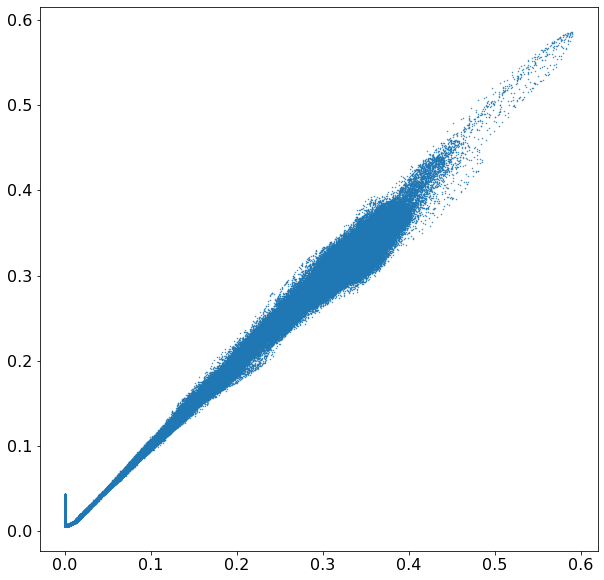

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(omega_DNS_filtered,omega_hat_predict_real,s=0.2)

## Compare omega vs c_tilde

Text(0, 0.5, 'omega')

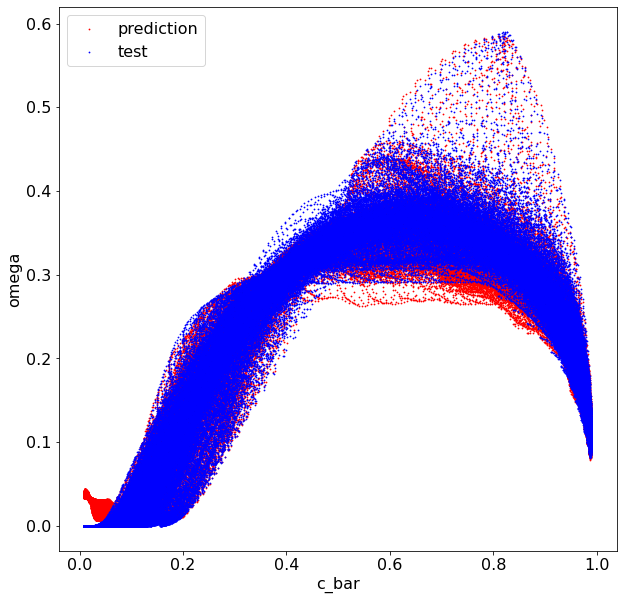

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(test_data_df['c_tilde'],omega_hat_predict_real,c='r',s=0.6)
plt.scatter(test_data_df['c_tilde'],test_data_df[TARGET],s=0.6,c='b')
plt.legend(['prediction','test'])
plt.xlabel('c_bar')
plt.ylabel('omega')

## Now apply the SHAP method

In [15]:
import shap
shap.initjs()

##############
# SHAP needs TF1.x
##############

In [16]:

SHAP_test_set = test_data_norm_df[FEATURES].sample(n=1000, random_state=0).to_numpy()

explainer = shap.DeepExplainer(DNN, SHAP_test_set)


In [17]:
shap_values = explainer.shap_values(SHAP_test_set)

In [18]:
location = 200


shap.force_plot(explainer.expected_value, shap_values[0][location,:], test_data_norm_df[FEATURES].iloc[location,:])

## Feature importance

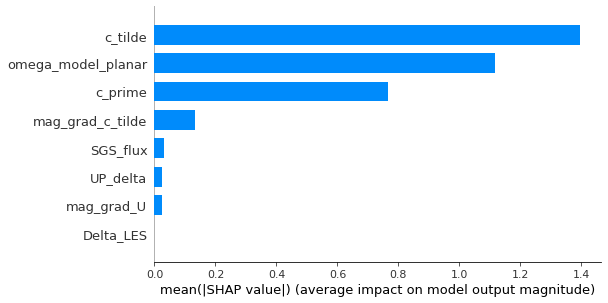

In [19]:

shap.summary_plot(shap_values[0], test_data_norm_df[FEATURES].sample(100),plot_type="bar")